In [1]:
import pprint
from pathlib import Path
from typing import cast

import matplotlib.pyplot as plt
import torch
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)
from colpali_engine.models import ColQwen2, ColQwen2Processor
from colpali_engine.utils.torch_utils import get_torch_device
from PIL import Image

In [2]:
def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    # Calculate the scaling factor
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # Resize the image
    scaled_image = image.resize((new_width, new_height))

    return scaled_image,width,height,new_width,new_height

In [3]:
model_name = "/huggingface/models/vidore/colqwen2-v0.1-merged"

device = get_torch_device("auto")
print(f"Using device: {device}")

# Load the model
model = cast(
    ColQwen2,
    ColQwen2.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
).eval()

# Load the processor
processor = cast(ColQwen2Processor, ColQwen2Processor.from_pretrained(model_name))

Using device: cuda:0


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


In [5]:
# ==========================     USER INPUTS     ==========================

image_filepath = Path("/Data/shift_kazakhstan.jpeg")
query = "Quelle partie de la production pétrolière du Kazakhstan provient de champs en mer ?"

# =========================================================================

assert image_filepath.is_file(), f"Cannot find the image file at `{image_filepath}`"
assert query, "Please write down your query."

image = Image.open(image_filepath)

# Preview the image
scale_image(image, 512)

(<PIL.Image.Image image mode=RGB size=454x512>, 1113, 1255, 454, 512)

In [6]:
# Preprocess inputs
batch_images = processor.process_images([image]).to(device)
batch_queries = processor.process_queries([query]).to(device)

# Forward passes
with torch.no_grad():
    image_embeddings = model.forward(**batch_images)
    query_embeddings = model.forward(**batch_queries)

In [7]:
# Get the number of image patches
n_patches = processor.get_n_patches(
    image_size=image.size,
    patch_size=model.patch_size,
    spatial_merge_size=model.spatial_merge_size,
)

print(f"Number of image patches: {n_patches}")

# Get the tensor mask to filter out the embeddings that are not related to the image
image_mask = processor.get_image_mask(batch_images)

Number of image patches: (26, 29)


In [8]:
# Generate the similarity maps
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=image_embeddings,
    query_embeddings=query_embeddings,
    n_patches=n_patches,
    image_mask=image_mask,
)

# Get the similarity map for our (only) input image
similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)

print(f"Similarity map shape: (query_length, n_patches_x, n_patches_y) = {tuple(similarity_maps.shape)}")

Similarity map shape: (query_length, n_patches_x, n_patches_y) = (43, 26, 29)


In [9]:
# Use this cell output to choose a token using its index
query_content = processor.decode(batch_queries.input_ids[0]).replace(processor.tokenizer.pad_token, "")
query_content = query_content.replace(processor.query_augmentation_token, "").strip()
query_tokens = processor.tokenizer.tokenize(query_content)

pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

{0: 'Query',
 1: ':',
 2: 'ĠQu',
 3: 'elle',
 4: 'Ġpartie',
 5: 'Ġde',
 6: 'Ġla',
 7: 'Ġproduction',
 8: 'Ġp',
 9: 'Ã©t',
 10: 'ro',
 11: 'li',
 12: 'Ã¨re',
 13: 'Ġdu',
 14: 'ĠKazakhstan',
 15: 'Ġprov',
 16: 'ient',
 17: 'Ġde',
 18: 'Ġchamps',
 19: 'Ġen',
 20: 'Ġmer',
 21: 'Ġ?'}


In [10]:
# Choose a token using its index
token_idx = 14  # e.g. if "3: 'Ġhour',", set 3 to choose the token 'Ġhour'

print(f"Selected token: `{query_tokens[token_idx]}`")

# Retrieve the similarity map for the chosen token
current_similarity_map = similarity_maps[token_idx]  # (n_patches_x, n_patches_y)

Selected token: `ĠKazakhstan`


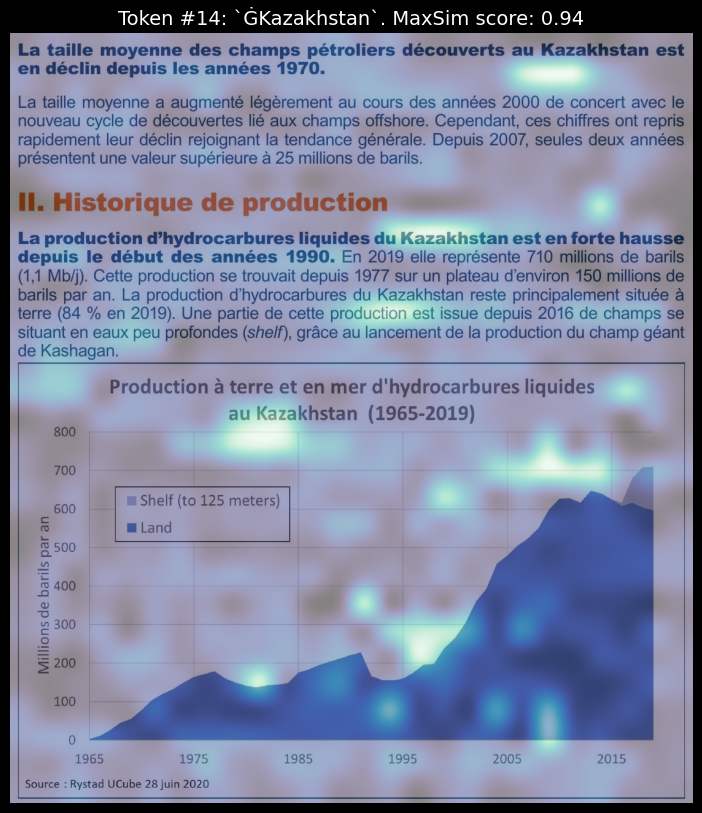

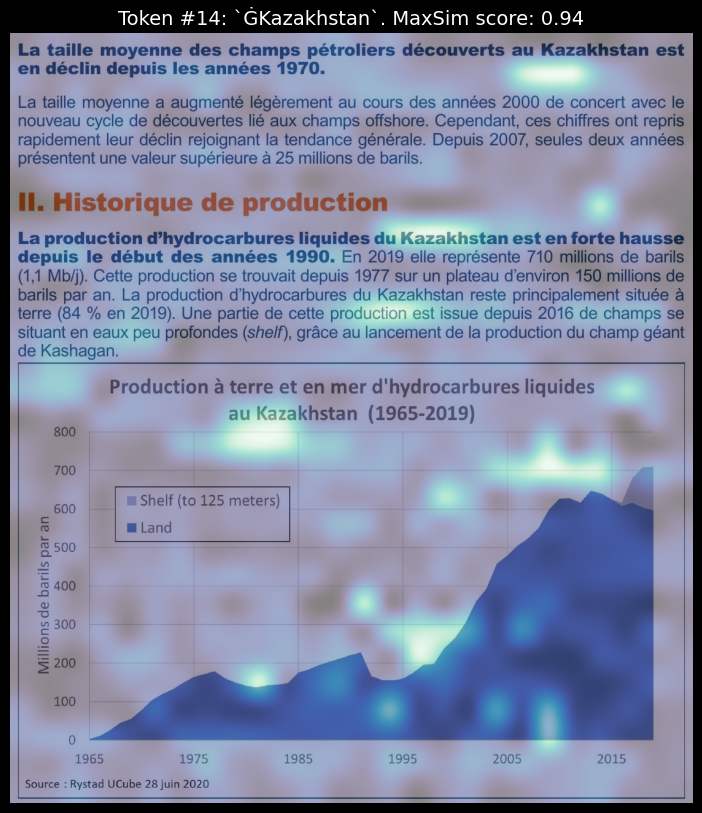

In [11]:
fig, ax = plot_similarity_map(
    image=image,
    similarity_map=current_similarity_map,
    figsize=(8, 8),
    show_colorbar=False,
)

max_sim_score = similarity_maps[token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

fig

In [ ]:
plots = plot_all_similarity_maps(
    image=image,
    query_tokens=query_tokens,
    similarity_maps=similarity_maps,
    figsize=(8, 8),
    show_colorbar=False,
    add_title=True,
)

for idx, (fig, ax) in enumerate(plots):
    savepath = f"/Data/image/kazakhstan_qwen/similarity_map_{idx}.png"
    fig.savefig(savepath, bbox_inches="tight")
    print(f"Similarity map for token `{query_tokens[idx]}` saved at `{savepath}`")

plt.close("all")

**对2019的图片进行分析**

In [13]:
# ==========================     USER INPUTS     ==========================

image_filepath = Path("/Data/energy_electricity_generation.jpg")
query = "Which hour of the day had the highest overall electricity generation in 2019?"
# 2019年一天中哪一个小时的总发电量最高？
# =========================================================================

assert image_filepath.is_file(), f"Cannot find the image file at `{image_filepath}`"
assert query, "Please write down your query."

image = Image.open(image_filepath)

# Preview the image
scale_image(image, 512)

(<PIL.Image.Image image mode=RGB size=722x512>, 1402, 994, 722, 512)

In [14]:
# Preprocess inputs
batch_images = processor.process_images([image]).to(device)
batch_queries = processor.process_queries([query]).to(device)

# Forward passes
with torch.no_grad():
    image_embeddings = model.forward(**batch_images)
    query_embeddings = model.forward(**batch_queries)

In [15]:
# Get the number of image patches
n_patches = processor.get_n_patches(
    image_size=image.size,
    patch_size=model.patch_size,
    spatial_merge_size=model.spatial_merge_size,
)

print(f"Number of image patches: {n_patches}")

# Get the tensor mask to filter out the embeddings that are not related to the image
image_mask = processor.get_image_mask(batch_images)

Number of image patches: (32, 23)


In [16]:
# Generate the similarity maps
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=image_embeddings,
    query_embeddings=query_embeddings,
    n_patches=n_patches,
    image_mask=image_mask,
)

# Get the similarity map for our (only) input image
similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)

print(f"Similarity map shape: (query_length, n_patches_x, n_patches_y) = {tuple(similarity_maps.shape)}")

Similarity map shape: (query_length, n_patches_x, n_patches_y) = (40, 32, 23)


In [17]:
# Use this cell output to choose a token using its index
query_content = processor.decode(batch_queries.input_ids[0]).replace(processor.tokenizer.pad_token, "")
query_content = query_content.replace(processor.query_augmentation_token, "").strip()
query_tokens = processor.tokenizer.tokenize(query_content)

pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

{0: 'Query',
 1: ':',
 2: 'ĠWhich',
 3: 'Ġhour',
 4: 'Ġof',
 5: 'Ġthe',
 6: 'Ġday',
 7: 'Ġhad',
 8: 'Ġthe',
 9: 'Ġhighest',
 10: 'Ġoverall',
 11: 'Ġelectricity',
 12: 'Ġgeneration',
 13: 'Ġin',
 14: 'Ġ',
 15: '2',
 16: '0',
 17: '1',
 18: '9',
 19: '?'}


In [18]:
# Choose a token using its index
token_idx = 3  # e.g. if "3: 'Ġhour',", set 3 to choose the token 'Ġhour'

print(f"Selected token: `{query_tokens[token_idx]}`")

# Retrieve the similarity map for the chosen token
current_similarity_map = similarity_maps[token_idx]  # (n_patches_x, n_patches_y)

Selected token: `Ġhour`


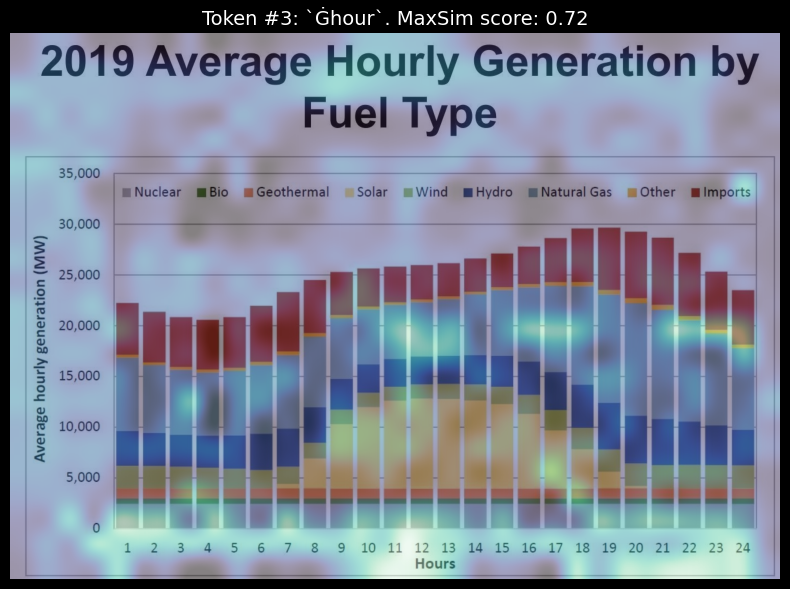

In [19]:
fig, ax = plot_similarity_map(
    image=image,
    similarity_map=current_similarity_map,
    figsize=(8, 8),
    show_colorbar=False,
)

max_sim_score = similarity_maps[token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

fig

In [ ]:
plots = plot_all_similarity_maps(
    image=image,
    query_tokens=query_tokens,
    similarity_maps=similarity_maps,
    figsize=(8, 8),
    show_colorbar=False,
    add_title=True,
)

for idx, (fig, ax) in enumerate(plots):
    savepath = f"/Data/image/energy_qwen/similarity_map_{idx}.png"
    fig.savefig(savepath, bbox_inches="tight")
    print(f"Similarity map for token `{query_tokens[idx]}` saved at `{savepath}`")

plt.close("all")